In [101]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import scipy.fftpack
from matplotlib import pyplot as plt
# importing bokeh
from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import row
from bokeh.plotting import figure
from ipywidgets import interact

output_notebook()
%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 12]

Loading BokehJS ...

In [2]:
def loaddata(filename, nrows=None):

    types = {'id': 'int64',
             'item_nbr': 'int32',
             'store_nbr': 'int16',
             'unit_sales': 'float32',
             'onpromotion': bool,
    }

    data = pd.read_csv(filename, parse_dates=['date'], 
                                     dtype=types, nrows=nrows, infer_datetime_format=True)

    return data

In [3]:
# Reading datasets
df_train = loaddata('data/train.csv')

/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [4]:
df_train.count()

id             125497040
date           125497040
store_nbr      125497040
item_nbr       125497040
unit_sales     125497040
onpromotion    103839389
dtype: int64

In [6]:
df_train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN


# Etude de la saisonalité 

In [8]:
global_sales_per_day = df_train[['date', 'unit_sales']].groupby('date').sum().reset_index()

In [30]:
p = figure(plot_width=1000, plot_height=400)
ts = p.line(global_sales_per_day.date.values, global_sales_per_day.unit_sales.values)

def update(period_length=1):
    ts.data_source.data['y'] = global_sales_per_day.unit_sales.rolling(period_length, center=True).mean()
    push_notebook()
    
show(p, notebook_handle=True)

### valeurs intéressantes : 1, multiples de 7, 364...

In [33]:
interact(update, period_length=(1, 365))

<function __main__.update>

# Analyse fréquentielle (FFT)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


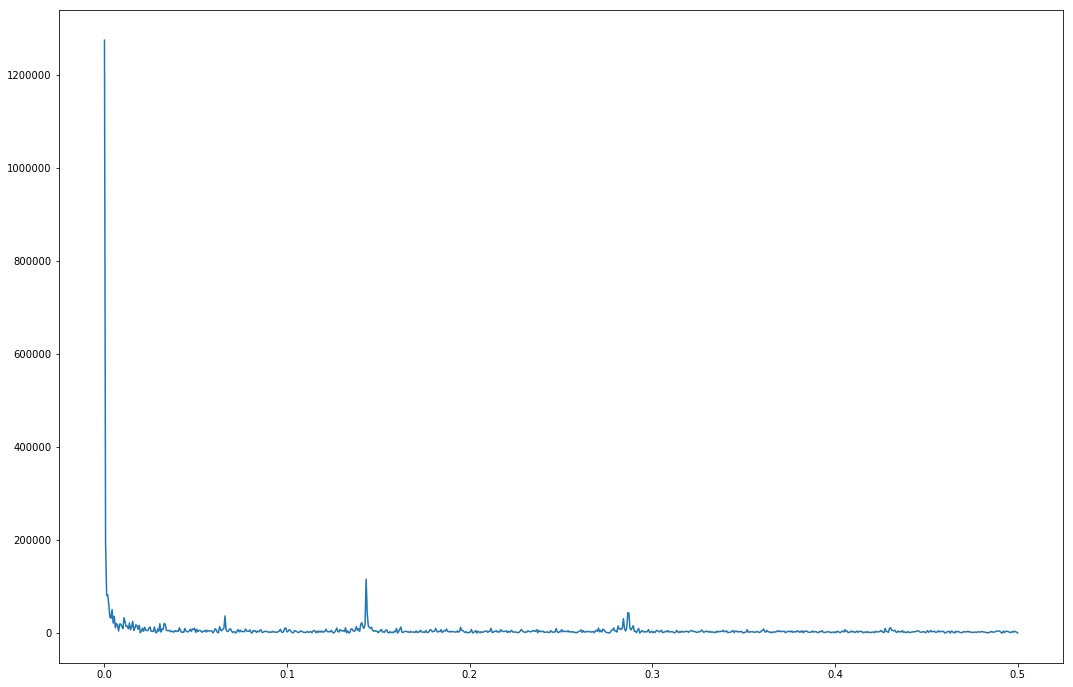

In [53]:
N = len(global_sales_per_day.unit_sales)
T = 1
x = np.linspace(1, N, N)
#y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
y = global_sales_per_day.unit_sales.values
yf = scipy.fftpack.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N/2)

fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.show()

# Modèle temporel global

In [103]:
# modele lineaire lisse sur l'annee (year to date)
x = np.linspace(0, N-1, N)
y = global_sales_per_day.unit_sales.rolling(364, center=True).mean()

# on met ca dans un df pour plus de simplicite
df_reg_lin = pd.DataFrame({'x':x, 'y':y})
df_reg_lin.dropna(inplace=True)
shp = len(df_reg_lin)

x_ = df_reg_lin.x.values.reshape(shp, 1)
y_ = df_reg_lin.y.values.reshape(shp, 1)

linreg = linear_model.LinearRegression()
linreg.fit(x_, y_)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [104]:
# The coefficients
print('Regression: \n', linreg.coef_[0][0]," * x + ", linreg.intercept_[0])
# Make predictions using the testing set
y_pred = linreg.coef_[0][0] * x_ + linreg.intercept_[0]
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_, y_pred))

Regression: 
 354.310947404  * x +  346340.60711
Variance score: 0.97


## Le r2 est encourageant...

# Modèle temporel avec saisonnalité :
On part du modèle précédent rendant compte de la croissance globale le long de la période et on ajoute la périodicite hebdo, on peut l'écrire : 
$$y = ax + b + c\sin(\omega t + \varphi)$$, avec $$\omega = 2\pi/T = 2\pi/7$$.

## on peut améliorer le modèle en faisant varier l'amplitude dans le temps

## à tester : ajouter un calque périodique annuel pour les cycles plus grands